In [7]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
import os
import google.generativeai as genai
from pydantic import BaseModel, Field

In [3]:
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI
model_name = "gemini-2.5-flash"  # or another available model
model = ChatGoogleGenerativeAI(model=model_name, api_key=os.getenv("GOOGLE_API_KEY"))

In [13]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="The sentiment of the text, e.g., positive, negative")

In [14]:
class DiagnoseSchema(BaseModel):
  issue_type: Literal["network", "hardware", "software"] = Field(description="Type of issue, e.g., network, hardware, software")
  tone : Literal["angry", "frustrated","unhappy","calm"] = Field(description=" the tone of the customer, e.g., angry, frustrated, unhappy, calm")
  urgency: Literal["low", "medium", "high"] = Field(description="urgency level of the issue, e.g., low, medium, high")

In [16]:
structured_model1 = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnoseSchema)

In [17]:
propmpt="what is the sentiment of the following review? 'The product quality is excellent and delivery was prompt.' "
structured_model1.invoke(propmpt).sentiment

'positive'

In [18]:
class reviewstate(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    sentiment:dict

In [36]:
def find_sentiment(state: reviewstate):
    prompt = f"what is the sentiment of the following review? '{state['review']}' "
    sentiment = structured_model1.invoke(prompt).sentiment
    return {'sentiment': sentiment}

In [37]:
def check_sentiment(state: reviewstate) -> Literal["positive_response", "run_diagnosis"]:
    if state['sentiment'] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"

In [38]:
def postive_response(state: reviewstate):
    propmt=f"Generate a positive response for the following review: '{state['review']}'"
    response = model.invoke(propmt).content
    return {"response": response} 

In [39]:
def run_diagnosis(state: reviewstate):
    prompt = f"Diagnose the following negative review and provide issue type, tone, and urgency: '{state['review']}'"
    response = structured_model2.invoke(prompt)
    return {"diagnosis": response.model_dump()}

In [40]:
def negative_response(state: reviewstate):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}
    

In [41]:
graph = StateGraph(reviewstate)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("check_sentiment", check_sentiment)
graph.add_node("positive_response", postive_response)
graph.add_node("negative_response", negative_response)
graph.add_node("run_diagnosis", run_diagnosis)

graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_sentiment)
graph.add_edge("positive_response", END)
graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

workflow = graph.compile()

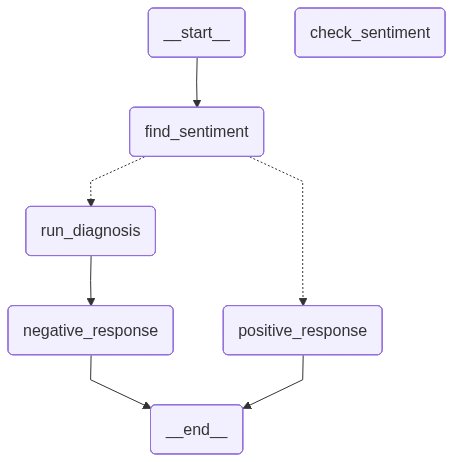

In [42]:
workflow

In [43]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'software',
  'tone': 'frustrated',
  'urgency': 'high'}}